### 1. 라이브러리 가져오기

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')

### 2. 데이터 전처리

In [2]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [3]:
# 날짜 처리
data = pd.read_csv('201901-202003.csv')
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4,2019,1
1,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8,2019,1
2,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6,2019,1
3,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5,2019,1
4,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3,2019,1


In [4]:
print(data.shape)
print(data.info())
print(data.isnull().sum())

(24697792, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24697792 entries, 0 to 24697791
Data columns (total 13 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   CARD_SIDO_NM  object
 1   CARD_CCG_NM   object
 2   STD_CLSS_NM   object
 3   HOM_SIDO_NM   object
 4   HOM_CCG_NM    object
 5   AGE           object
 6   SEX_CTGO_CD   int64 
 7   FLC           int64 
 8   CSTMR_CNT     int64 
 9   AMT           int64 
 10  CNT           int64 
 11  year          int64 
 12  month         int64 
dtypes: int64(7), object(6)
memory usage: 2.4+ GB
None
CARD_SIDO_NM         0
CARD_CCG_NM      87213
STD_CLSS_NM          0
HOM_SIDO_NM          0
HOM_CCG_NM      147787
AGE                  0
SEX_CTGO_CD          0
FLC                  0
CSTMR_CNT            0
AMT                  0
CNT                  0
year                 0
month                0
dtype: int64


In [5]:
# 데이터 정제
df = data.copy()
df = df.drop(['CARD_CCG_NM','HOM_CCG_NM','CSTMR_CNT','CNT'], axis=1)

columns = ['CARD_SIDO_NM','STD_CLSS_NM','HOM_SIDO_NM',
           'AGE','SEX_CTGO_CD','FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)
df.head()

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month,AMT
0,강원,건강보조식품 소매업,강원,20s,1,1,2019,1,311200
1,강원,건강보조식품 소매업,강원,20s,1,1,2019,2,605000
2,강원,건강보조식품 소매업,강원,20s,1,1,2019,6,139000
3,강원,건강보조식품 소매업,강원,20s,1,1,2019,8,27500
4,강원,건강보조식품 소매업,강원,20s,1,1,2019,9,395500


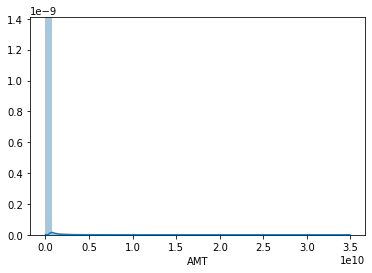

In [6]:
# 타깃 값이 정규 분포인지 확인
sns.distplot(df['AMT'])

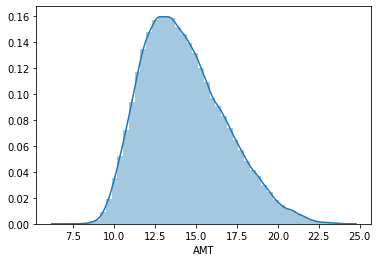

In [7]:
# 로그 변환 후 학습, 예측 시 다시 결괏값을 expm1()으로 환원
log_AMT = np.log1p(df['AMT'])
sns.distplot(log_AMT)

In [8]:
# AMT 로그 변환
org_AMT = df['AMT']
df['AMT'] = np.log1p(df['AMT'])

In [9]:
# 문자열 피처 원핫인코딩
print('get_dummies() 수행 전 데이터 Shape: ', df.shape)
df_ohe = pd.get_dummies(df)
print('get_dummies() 수행 후 데이터 Shape: ', df_ohe.shape)

get_dummies() 수행 전 데이터 Shape:  (1057394, 9)
get_dummies() 수행 후 데이터 Shape:  (1057394, 87)


In [10]:
df_ohe.head()

,SEX_CTGO_CD,FLC,year,month,AMT,CARD_SIDO_NM_강원,CARD_SIDO_NM_경기,CARD_SIDO_NM_경남,CARD_SIDO_NM_경북,CARD_SIDO_NM_광주,...,HOM_SIDO_NM_제주,HOM_SIDO_NM_충남,HOM_SIDO_NM_충북,AGE_10s,AGE_20s,AGE_30s,AGE_40s,AGE_50s,AGE_60s,AGE_70s
0,1,1,2019,1,12.648194,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,2019,2,13.312985,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,1,2019,6,11.842236,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,1,2019,8,10.221978,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,2019,9,12.887909,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [11]:
# 칼럼별로 원핫인코딩 (One-Hot-Encoding)
# CARD_SIDO_NM
# oh_encoder = OneHotEncoder(categories='auto')
# arr_CARD_SIDO_NM = df_num['CARD_SIDO_NM'].to_numpy().reshape(-1,1)
# oh_encoder.fit(arr_CARD_SIDO_NM)
# oh_CARD_SIDO_NM = oh_encoder.transform(arr_CARD_SIDO_NM)
# print(oh_CARD_SIDO_NM.toarray())
# print(oh_CARD_SIDO_NM.shape)

### 3. 회귀 트리 모델 학습/예측/평가

- 타깃 값인 AMT가 로그 변환됨.
- 예측값 역시 해당 타깃 값을 기반으로 예측하므로 원본 AMT 예측값의 로그 변환 값임.
- 따라서 예측 결과 오류에 RMSE만 적용하면 RMSLE가 자동으로 측정
- 여러 모델의 로그 변환된 RMSE를 측정할 것이므로 이를 계산하는 함수 생성

In [12]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, '로그 변환된 RMSE:', np.round(rmse, 3))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [13]:
y_target = df_ohe['AMT']
X_features = df_ohe.drop('AMT', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

In [14]:
def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                            np.round(rmse, 4), grid_model.best_params_))

In [15]:
xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값:2.4851, 최적 alpha:{'n_estimators': 1000}


In [16]:
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

### 4. 결과 및 결연

In [17]:
# 예측 템플릿 만들기
CARD_SIDO_NMs = data['CARD_SIDO_NM'].unique()
STD_CLSS_NMs = data['STD_CLSS_NM'].unique()
HOM_SIDO_NMs = data['HOM_SIDO_NM'].unique()
AGEs = data['AGE'].unique()
SEX_CTGO_CDs = data['SEX_CTGO_CD'].unique()
FLCs = data['FLC'].unique()
years = [2020]
months = [4, 7]

In [18]:
x = df.drop(['AMT'], axis=1, inplace=False)

In [19]:
temp = []
for CARD_SIDO_NM in CARD_SIDO_NMs:
    for STD_CLSS_NM in STD_CLSS_NMs:
        for HOM_SIDO_NM in HOM_SIDO_NMs:
            for AGE in AGEs:
                for SEX_CTGO_CD in SEX_CTGO_CDs:
                    for FLC in FLCs:
                        for year in years:
                            for month in months:
                                temp.append([CARD_SIDO_NM, STD_CLSS_NM,
                                             HOM_SIDO_NM, AGE, SEX_CTGO_CD,
                                             FLC, year, month])
temp = np.array(temp)
temp = pd.DataFrame(data=temp, columns=x.columns)
temp

,CARD_SIDO_NM,STD_CLSS_NM,HOM_SIDO_NM,AGE,SEX_CTGO_CD,FLC,year,month
0,강원,건강보조식품 소매업,강원,20s,1,1,2020,4
1,강원,건강보조식품 소매업,강원,20s,1,1,2020,7
2,강원,건강보조식품 소매업,강원,20s,1,2,2020,4
3,강원,건강보조식품 소매업,강원,20s,1,2,2020,7
4,강원,건강보조식품 소매업,강원,20s,1,3,2020,4
...,...,...,...,...,...,...,...,...
1658855,충북,정기 항공 운송업,제주,10s,2,3,2020,7
1658856,충북,정기 항공 운송업,제주,10s,2,4,2020,4
1658857,충북,정기 항공 운송업,제주,10s,2,4,2020,7
1658858,충북,정기 항공 운송업,제주,10s,2,5,2020,4


In [20]:
temp['SEX_CTGO_CD'] = temp['SEX_CTGO_CD'].map(lambda x : int(x))
temp['FLC'] = temp['FLC'].map(lambda x : int(x))
temp['year'] = temp['year'].map(lambda x : int(x))
temp['month'] = temp['month'].map(lambda x : int(x))

In [21]:
# 문자열 피처 원핫인코딩
print('get_dummies() 수행 전 데이터 Shape: ', temp.shape)
temp_ohe = pd.get_dummies(temp)
print('get_dummies() 수행 후 데이터 Shape: ', temp_ohe.shape)

get_dummies() 수행 전 데이터 Shape:  (1658860, 8)
get_dummies() 수행 후 데이터 Shape:  (1658860, 86)


In [22]:
temp_ohe.head()

,SEX_CTGO_CD,FLC,year,month,CARD_SIDO_NM_강원,CARD_SIDO_NM_경기,CARD_SIDO_NM_경남,CARD_SIDO_NM_경북,CARD_SIDO_NM_광주,CARD_SIDO_NM_대구,...,HOM_SIDO_NM_제주,HOM_SIDO_NM_충남,HOM_SIDO_NM_충북,AGE_10s,AGE_20s,AGE_30s,AGE_40s,AGE_50s,AGE_60s,AGE_70s
0,1,1,2020,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,2020,7,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,2,2020,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,1,2,2020,7,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,1,3,2020,4,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [23]:
# 예측
pred = xgb_reg.predict(temp_ohe)
pred = np.expm1(pred)
temp['AMT'] = np.round(pred, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [24]:
# 제출 파일 만들기
submission = pd.read_csv('./submission.csv', index_col=0)
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission.index.name = 'id'
submission.to_csv('./submission8_XGB.csv', encoding='utf-8-sig')
submission8 = pd.read_csv('./submission8_XGB.csv')
submission8.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,3.109361e+08
1,1,202004,강원,골프장 운영업,1.384156e+09
2,2,202004,강원,과실 및 채소 소매업,6.506903e+08
3,3,202004,강원,관광 민예품 및 선물용품 소매업,6.242800e+07
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,3.218340e+07


### 5. RMSLE 확인

In [71]:
amt_per_mean = pd.read_csv('amt_per_mean.csv')
amt_per_mean = amt_per_mean.drop(['Unnamed: 0','AMT_per_2','AMT_per_3','AMT_per_4'], axis=1, inplace=False)
amt_per_mean.head()

,CARD_SIDO_NM,STD_CLSS_NM,AMT_per_mean
0,강원,건강보조식품 소매업,0.744281
1,강원,골프장 운영업,1.028089
2,강원,과실 및 채소 소매업,1.063497
3,강원,관광 민예품 및 선물용품 소매업,0.682884
4,강원,그외 기타 스포츠시설 운영업,0.350761


In [72]:
submission8.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,3.109361e+08
1,1,202004,강원,골프장 운영업,1.384156e+09
2,2,202004,강원,과실 및 채소 소매업,6.506903e+08
3,3,202004,강원,관광 민예품 및 선물용품 소매업,6.242800e+07
4,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,3.218340e+07


In [73]:
total_data = pd.merge(submission8, amt_per_mean, how='outer')
total_data = total_data.sort_values(by='id')
total_data.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT,AMT_per_mean
0,0,202004,강원,건강보조식품 소매업,3.109361e+08,0.744281
2,1,202004,강원,골프장 운영업,1.384156e+09,1.028089
4,2,202004,강원,과실 및 채소 소매업,6.506903e+08,1.063497
6,3,202004,강원,관광 민예품 및 선물용품 소매업,6.242800e+07,0.682884
8,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,3.218340e+07,NaN


In [74]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394 entries, 0 to 1393
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            1394 non-null   int64  
 1   REG_YYMM      1394 non-null   int64  
 2   CARD_SIDO_NM  1394 non-null   object 
 3   STD_CLSS_NM   1394 non-null   object 
 4   AMT           1394 non-null   float64
 5   AMT_per_mean  1284 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 76.2+ KB


In [75]:
total_data['AMT_per_mean'] = total_data['AMT_per_mean'].fillna(1)

In [76]:
total_data['AMT'] = total_data['AMT'] * total_data['AMT_per_mean']
total_data = total_data.drop(['AMT_per_mean'], axis=1, inplace=False)
total_data.head()

,id,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,AMT
0,0,202004,강원,건강보조식품 소매업,2.314238e+08
2,1,202004,강원,골프장 운영업,1.423035e+09
4,2,202004,강원,과실 및 채소 소매업,6.920074e+08
6,3,202004,강원,관광 민예품 및 선물용품 소매업,4.263110e+07
8,4,202004,강원,그외 기타 분류안된 오락관련 서비스업,3.218340e+07


In [82]:
total_data.to_csv('submission10_XGB.csv', encoding='utf-8-sig')

In [77]:
def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

In [78]:
correct = pd.read_csv('202004.csv')
correct = correct.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [79]:
correct.head()

,REG_YYMM,CARD_SIDO_NM,STD_CLSS_NM,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,202004,강원,건강보조식품 소매업,106,271,782,88823988,862
1,202004,강원,골프장 운영업,2583,7708,25172,4708346820,32298
2,202004,강원,과실 및 채소 소매업,2316,5475,23201,1121028924,33123
3,202004,강원,관광 민예품 및 선물용품 소매업,206,445,582,14360780,702
4,202004,강원,그외 기타 스포츠시설 운영업,2,6,6,227200,14


In [81]:
rmsle(correct['AMT'], total_data['AMT'])

3.589108883782354